In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 17 15:34:23 2020

@author: LeeHJ, ShinJS, JangSJ
"""

import pymysql
import pandas as pd
import numpy as np
import datetime as dt
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as optm
from matplotlib.dates import MonthLocator, DateFormatter, WeekdayLocator
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
### DB 접속
stock_db = pymysql.connect(
    user='crawler',
    passwd='crawler123!',
    host='172.30.1.46', 
    #host='137.68.198.32', 
    port=3306,
    db='stockdata', 
    charset='utf8'
    )
cur = stock_db.cursor()

const_exit = '#exit'

### id / password 확인

In [13]:
sql = "SELECT * FROM TB_USER WHERE ID = '%s'" % 'test'

In [15]:
print('\n[SQL-log] '+sql+"\n")  


[SQL-log] SELECT * FROM TB_USER WHERE ID = 'test'



In [17]:
cur.execute(sql)
res = cur.fetchone()
print(res)

(23001, 'test', 'haha', 'sj', datetime.date(1995, 10, 10), 10)


In [19]:
pd.isnull(res)

False

In [23]:
if pd.isnull(res):
    False, -1, print("존재하지 않는 ID 입니다.")
elif res[2] != 'haha':
    False, -2, print("잘못된 비밀번호 입니다.")
else:
    True, res[0], print("로그인 성공, '" + res[3] +"'님 환영합니다.")

로그인 성공, 'sj'님 환영합니다.


### 로그인 실행

In [25]:
res = False
user_id = -1
while(res == False):
    print('\n\nlogin: ID 를 입력해주세요. (나가기 : exit!!)')
    ip = input()
    if ip == 'exit!!': res[0] (False, -1)
    id = ip
        
    print('\n\nlogin: PW 를 입력해주세요. (나가기 : exit!!)')
    ip = input()
    if ip == 'exit!!': res[0] (False, -1)
    pw = ip
        
    #print(id, pw)
    res, user_id, msg = idpw_check(id, pw)
    print(msg)
    print()
    print( res, user_id )



login: ID 를 입력해주세요. (나가기 : exit!!)
test


login: PW 를 입력해주세요. (나가기 : exit!!)
haha

[SQL-log] SELECT * FROM TB_USER WHERE ID = 'test'

(23001, 'test', 'haha', 'sj', datetime.date(1995, 10, 10), 10)
로그인 성공, 'sj'님 환영합니다.

True 23001


In [5]:
### 회원가입!
def register_id(id, pw):
    res = idpw_check(id, pw)
    # 존재하지 않는 ID, 회원가입 처리
    if(res[0] == False and res[1] == -1):
        print('\n\nregister: 이름을 입력해주세요. (나가기 : exit!!)')
        ip = input()
        if ip == 'exit!!': return (False, -1)
        name = ip
        
        print('\n\nregister: 생년월일을 입력해주세요. ex. 1990-01-01 (나가기 : exit!!)')
        ip = input()
        if ip == 'exit!!': return (False, -1)
        birth = ip
        birth = dt.datetime.strptime(birth,'%Y-%m-%d').date()
        
        print('\n\nregister: 부양 가족 수를 입력해주세요. (나가기 : exit!!)')
        ip = input()
        if ip == 'exit!!': return (False, -1)
        f_num = ip
        
        print(id, pw, name, birth, f_num)
        
        u_id = str(uuid.uuid4().fields[-1])[:5]
        sql = "INSERT INTO TB_USER VALUES(%s, '%s', '%s', '%s', '%s', %s)" % (u_id, id, pw, name, birth, f_num)
    
        print('\n[SQL-log] '+sql+"\n")   
        cur.execute(sql)
        
        res, user_id, msg = idpw_check(id, pw)
        
        stock_db.commit()
        
        return (res, user_id, msg)
        
    else:
        return (False, -1, "이미 존재하는 ID 입니다.")

In [6]:
def do_register():
    res = False
    user_id = -1
    
    while(res == False):
        print('\n\nregister: ID 를 입력해주세요. (나가기 : exit!!)')
        ip = input()
        if ip == 'exit!!': return (False, -1)
        id = ip
        
        print('\n\nregister: PW 를 입력해주세요. (나가기 : exit!!)')
        ip = input()
        if ip == 'exit!!': return (False, -1)
        pw = ip
        
        #print(id, pw)
        res, user_id, msg = register_id(id, pw)
        print(msg)
    
    return res, user_id

### 투자성향 조사

In [27]:
    iv_period = 1
    
    # 설문 문제 LIST 추출
    sql = "SELECT * FROM TB_SURV_QUES"
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    res = cur.fetchall()
    
    ans_li = []
    print('\n')
    print("< 투자성향 조사 >")


[SQL-log] SELECT * FROM TB_SURV_QUES



< 투자성향 조사 >


In [7]:
### 투자성향 조사!
def do_survey(user_id):
    iv_period = 1
    
    # 설문 문제 LIST 추출
    sql = "SELECT * FROM TB_SURV_QUES"
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    res = cur.fetchall()
    
    ans_li = []
    print('\n')
    print("< 투자성향 조사 >")
    for ques in list(res):
        
        # 문제에 대한 답변 리스트 호출.
        sql = "SELECT * FROM TB_SURV_ANS WHERE QUES = %s" % ques[0]
        print('\n[SQL-log] '+sql+"\n")
        cur.execute(sql)
        show_ans = cur.fetchall()
        
        tmp_acc = False
        while(tmp_acc == False):
            
            print()
            print(str(ques[0]) + ". " + ques[1])
        
            for show in list(show_ans):
                print("   "+str(show[1]) + ") " + show[2])
            
            try:
                u_ans = int(input())
                
                if u_ans >= 1 and u_ans <= len(show_ans):
                    tmp_acc = True
                else:
                    print('잘못된 값이 입력되었습니다.')
            except:
                print('잘못된 값이 입력되었습니다.')
        ans_li.append(u_ans)
    
    tmp_acc = False
    while(tmp_acc == False):
        print()
        print('** 실제 투자할 기간을 선택해주세요. **')
        print('  1) 3M')
        print('  2) 6M')
        print('  3) 1Y')
        try:
            iv_period = int(input())
            
            if iv_period >= 1 and iv_period <= 3:
                tmp_acc = True
            else:
                print('잘못된 값이 입력되었습니다.')
        except:
            print('잘못된 값이 입력되었습니다.')
    if iv_period == 1: iv_period = '3M'
    if iv_period == 2: iv_period = '6M'
    if iv_period == 3: iv_period = '1Y'
    
    print(ans_li)
    print('투자기간 : ' + iv_period)
    
    sql = "SELECT IFNULL(MAX(SRNO),0) + 1 FROM TB_SURV WHERE USER_ID = '%s'" % user_id
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    srno = cur.fetchone()
    srno = srno[0]
    
    
    sql = "INSERT INTO TB_SURV VALUES( %s, %s, now(), '%s', 0)" %(user_id, srno, iv_period)
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    
    
    sql = "INSERT INTO TB_SURV_DETAIL VALUES( %s, %s, %s, %s)"
    
    surv_detail = pd.DataFrame(np.array([np.arange(1,7),ans_li]).T, columns=['ques','ans'])
    surv_detail['user_id'] = user_id
    surv_detail['srno'] = srno
    surv_detail = surv_detail[['user_id','srno','ques','ans']]
    val = np.array(surv_detail).tolist()
    print('\n[SQL-log] '+sql+"\n")
    cur.executemany(sql,val)
    
    # P_DATA = 새 고객이 제출한 고객정보와 고객정보 답에 따른 SCORE를 비교하여 같은 것을 가져옴
    # R_DATA = 새 고객이 제출한 설문지 답과 설문지 답에 따른 SCORE를 비교하여 같을 것을 가여좀
    # C_2 = 모든 경우의 수의 고객정보와 설문지 답
    
    sql = """
    UPDATE   TB_SURV A
       SET   CLASS = (
                      SELECT C_S.CLASS
                      FROM
                         (
                         SELECT USER_ID, AGE_T.USER_SCORE + FAMILY_T.USER_SCORE AS P_SCORE
                            FROM TB_USER 
                               ,(SELECT MIN, MAX, USER_SCORE
                                FROM TB_USER_SCORE
                                WHERE USER_INFO = 'AGE') AS AGE_T
                               ,(SELECT MIN, MAX, USER_SCORE
                                FROM TB_USER_SCORE
                                WHERE USER_INFO = 'FAMILY_NUM') AS FAMILY_T
                            WHERE (YEAR(NOW()) - YEAR(BIRTH) + 1) BETWEEN AGE_T.MIN AND AGE_T.MAX
                            AND TB_USER.FAMILY_NUM BETWEEN FAMILY_T.MIN AND FAMILY_T.MAX
                          ) AS P_DATA,
                         (
                            SELECT A.USER_ID, A.SRNO, SUM(B.SCORE) AS R_SCORE
                            FROM TB_SURV_DETAIL A, TB_SURV_ANS B
                            WHERE A.QUES = B.QUES
                              AND A.ANS = B.ANS
                              GROUP BY USER_ID, SRNO
                         ) AS R_DATA 
                         , TB_CLASS_SCORE AS C_S
                      WHERE P_DATA.USER_ID = R_DATA.USER_ID
                        AND C_S.R_SCORE = R_DATA.R_SCORE
                        AND C_S.P_SCORE = P_DATA.P_SCORE
                        AND R_DATA.USER_ID = A.USER_ID
                        AND R_DATA.SRNO = A.SRNO
                  )
     WHERE   USER_ID = %s
       AND  SRNO = %s
    """ %(user_id, srno)
    
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    
    stock_db.commit()
    print(val)
    
    return (user_id, srno)

### 과거 히스토리 조회

In [8]:
### 과거 히스토리 조회!
def load_history(user_id):
    ans = 0
    sql = """
    SELECT A.USER_ID, A.SRNO, A.SURV_DATE, A.PERIOD, A.CLASS, B.DETAIL
    FROM TB_SURV A,TB_CLASS B 
    WHERE A.CLASS = B.CLASS AND USER_ID = %s
    """ % user_id
   
    print('\n[SQL-log] '+sql+"\n")          
    cur.execute(sql)
    res = cur.fetchall()
    
    if res == ():
        print('추천받은 포트폴리오 내역이 없습니다.\n')
        return False, res
        
    tmp_acc = False
    while(tmp_acc == False):
        print()          
        print('< history >')
        print("  0. exit")
        for surv in res:
            print("  %d. 투자기간(%s) / 투자성향(%s) / 일시(%s)" %(surv[1],surv[3],surv[5],surv[2]))
        try:
            
            print('- 확인하고 싶은 포트폴리오를 선택해주세요.')
            ans = int(input())
            
            if ans >= 1 and ans <= len(res):
                tmp_acc = True
            elif ans == 0:
                return False, res
            else:
                print('잘못된 값이 입력되었습니다.')
        except:
            print('잘못된 값이 입력되었습니다.')
    return True, res[ans-1]

### 투자종목 추천

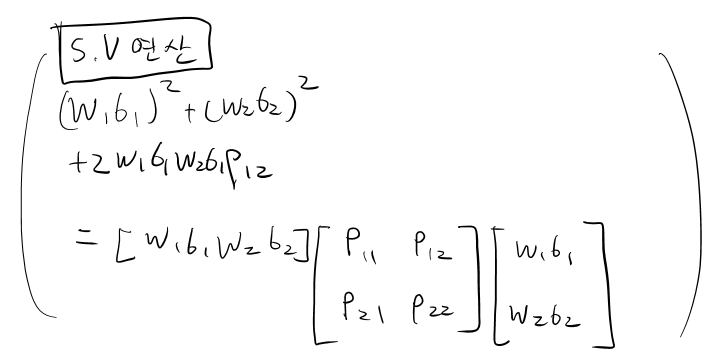

In [9]:
### 포트폴리오 최적화 목적함수
def op_func(w, idx_info, corr_info, rf):
    # 행렬 곱 해준것
    excess_return = np.dot(w, idx_info['mean']) - rf
    # Standard Deviation을 행렬연산으로 구해준 것
    std = np.dot(np.dot((idx_info['sd'] * w).T, corr_info), idx_info['sd'] * w)
    # minimize 해주는 최적화밖에 없으므로 Sharp Ratio maximize해주도록 -를 붙여줌
    return - excess_return / std    

In [10]:
### 포트폴리오 구성하기
def make_pf(user_id, srno):
    
    #1. 투자기간, 투자성향, risk-free rate 구하기.
    #START DATE = 영업일에 없는 날짜면 PRICE 데이터에있는 가장 최근 날짜로 가져옴
    #END DATE = STAT 데이터와 PRICE 데이터 중 적은 날짜로 설정
    #(1) 조정된 START DATE, END DATE / (2) PERIOD / (3) CLASS / (4) USER_ID / (5) SRNO 에 맞는
    #USER ID / SRNO / PERIOD / CLASS / START_DATE / END_DATE / 3개월전날짜 / 6개월전날짜 / 1년전날짜 / rf 가져오기
    sql = """
    SELECT USER_ID, SRNO, PERIOD, CLASS, START_DATE, END_DATE, 3M, 6M, 1Y
         ,(SELECT AVG(CLOSE) FROM TB_STK_PRICE 
           WHERE TICKER = 'KR1YT' 
             AND K_DATE BETWEEN REQ.START_DATE AND REQ.END_DATE) AS RF_RATE
    FROM
        (
            SELECT A.USER_ID, A.SRNO, A.PERIOD, A.CLASS, 
                   CASE WHEN B.PERIOD = '3M' THEN B.3M
                        WHEN B.PERIOD = '6M' THEN B.6M
                        WHEN B.PERIOD = '1Y' THEN B.1Y
                        ELSE B.1Y END AS START_DATE, B.END_DATE, B.3M, B.6M, B.1Y
            FROM TB_SURV A,
                (
                    SELECT  USER_ID, SRNO
                          , (SELECT MAX(K_DATE) FROM TB_ETF_PRICE WHERE K_DATE <= DATE(SURV_DATE) - INTERVAL 3 MONTH) AS 3M
                          , (SELECT MAX(K_DATE) FROM TB_ETF_PRICE WHERE K_DATE <= DATE(SURV_DATE) - INTERVAL 6 MONTH) AS 6M
                          , (SELECT MAX(K_DATE) FROM TB_ETF_PRICE WHERE K_DATE <= DATE(SURV_DATE) - INTERVAL 1 YEAR ) AS 1Y
                          , DATE( LEAST( (SELECT MAX(K_DATE) FROM TB_ETF_PRICE WHERE K_DATE <= DATE(SURV_DATE))
                                 ,(SELECT MAX(SURV_DATE) FROM TB_ETF_STAT) ) 
                                 ) AS END_DATE
                          , PERIOD, CLASS
                    FROM TB_SURV
                    WHERE USER_ID = %s
                      AND SRNO = %s
                ) B
            WHERE A.USER_ID = B.USER_ID
              AND A.SRNO = B.SRNO
        ) REQ
    """ %(user_id, srno)
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    res = cur.fetchone()
    print(res)
    
    iv_period, r_class, start_date, end_date, _3m, _6m, _1y, rf = res[2:]
    rf = float(rf)
    
    #2. 불러온 투자기간, 투자성향에 따라 투자할 ETF 종목 선정
    #(1) 투자기간 & CLASS & 설문날짜를 받아서 TICKER 및 투자기간별로 갯수를 통해 정확도 산출하여 10개 추출
    #(2) Sharp Ratio로 5개 추출
    sql = """
    SELECT    A.TICKER
            , A.MEAN * B.MULTIPLE      AS ANNUALIZED_MEAN
            , A.SD * SQRT(B.MULTIPLE)  AS ANNUALIZED_SD
            , A.SR * SQRT(B.MULTIPLE)  AS ANNUALIZED_SR
            , B.MULTIPLE
            
    FROM tb_etf_stat A,
       (
          select TICKER, PERIOD, COUNT(*) AS CNT,
                    CASE WHEN PERIOD = '3M' THEN 63
                         WHEN PERIOD = '6M' THEN 126
                         WHEN PERIOD = '1Y' THEN 252
                         ELSE 252 END AS MULTIPLE
          FROM tb_etf_stat A
          WHERE PERIOD = '%s'
          AND CLASS = '%s'
            AND SURV_DATE BETWEEN DATE_SUB(DATE(NOW()), INTERVAL 1 YEAR) AND '%s'
          GROUP BY TICKER, PERIOD
          ORDER BY CNT DESC 
          LIMIT 10
       ) B
    WHERE A.TICKER = B.TICKER 
    AND A.PERIOD = B.PERIOD
    AND A.SURV_DATE = '%s'
    ORDER BY SR DESC
    LIMIT 5
    ;
    """ %  (iv_period, r_class, end_date, end_date)
    print('\n[SQL-log] '+sql+"\n")
    cur.execute(sql)
    pf = cur.fetchall()
    pf = pd.DataFrame(pf, columns=['ticker','sd','mean','sr','multi'])
    pf['sd'] = pf['sd'].map(float)
    pf['mean'] = pf['mean'].map(float)
    pf['ticker'] = pf['ticker'].map(int)
    
    print(pf)
    
    #3. 투자할 ETF 종목에 대해서 과거 투자기간에 대해서 최적의 S.R를 산출하도록 최적화 MVO.
    #3-1. ETF 종목들에 대해 과거 투자기간 동안의 Corr 계산.
    price_li = []
    for tk in pf.ticker:
        
        sql = """
        SELECT TICKER, K_DATE, PCT_CHANGE
        FROM TB_ETF_PRICE
        WHERE TICKER = %s
        AND K_DATE BETWEEN '%s' AND '%s'
        """% (tk, start_date, end_date)
        
        print('\n[SQL-log] '+sql+"\n")
        cur.execute(sql)
        tk_price = cur.fetchall()
        
        tk_price = pd.Series(list(map(lambda x:float(x[2]), tk_price)), name=tk)
        price_li.append(tk_price)
    
    corr = pd.DataFrame(price_li).T.corr()
    
    #범위 제약 ( 0.05 ~ 0.5 )
    bnds = tuple([(0.05, 0.5)] * len(pf))
    #제약 조건 ( 비중의 합은 1 )
    cons = [{'type':'eq', 'fun': lambda x: sum(x) - 1 }]
    #op_func : 최적화할 대상 / x0 : 시작점 (동일비중) / bounds : 범위제약 / constarints : 제약
    #args : input 변수 / w (op_func 안에서) : input으로 넣지 않았으므로 해가 됨
    sol = optm.minimize(op_func, x0=[ 1/len(pf) ] * len(pf), bounds=bnds, constraints=cons, args=(pf,corr,rf))    
    data = pd.DataFrame(np.array([list(pf.ticker), list(map(lambda x:round(x,3),sol.x))]).T, columns=['ticker','weight'])
    data['ticker'] = data['ticker'].map(int)
    data['user_id'] = user_id
    data['srno'] = srno
    data['num'] = range(len(data))
    data = data[['user_id','srno','num','ticker','weight']]
    
    sql = "INSERT INTO TB_PORT_DETAIL VALUES( %s, %s, %s, %s, %s)"
    val = np.array(data).tolist()
    print('\n[SQL-log] '+sql+"\n")
    print(data)
    
    cur.executemany(sql, val)
    stock_db.commit()

In [11]:
### 파이 시각화!
def visualize_pie(user_id, srno):
    sql = """
    SELECT B.USER_ID, B.SRNO, D.CLASS, D.DETAIL, B.NUM, B.TICKER, B.WEIGHT, C.TICKER_NAME
    FROM TB_SURV A, TB_PORT_DETAIL B, TB_ETF_INFO C, TB_CLASS D
    WHERE A.USER_ID = B.USER_ID
      AND A.SRNO = B.SRNO
      AND B.TICKER = C.TICKER
      AND A.CLASS = D.CLASS
      AND A.USER_ID = %s
      AND A.SRNO = %s
    ORDER BY B.NUM, B.TICKER, B.WEIGHT
    """ % (user_id, srno)
    
    print('\n[SQL-log] '+sql+"\n")   
    cur.execute(sql)
    pf = cur.fetchall()
    pf = pd.DataFrame(pf, columns=['user_id', 'srno', 'class', 'c_name','num', 'ticker', 'weight', 't_name'])
    
    #테마설정
    sns.set_style('dark')
    #한글폰트 안깨지도록 하기
    plt.rcParams['font.family'] = 'NanumGothic'
    #폰트 크기 설정
    plt.rcParams['font.size'] = 20
    #시각화
    plt.figure(figsize = (16,10))
    
    font1 = {'color':  'red',
          'weight': 'normal',
          'size': 30}
    plt.text(-1.8, 1.2, "<고객성향 : " + pf['c_name'][0] + ">", fontdict = font1)
    
    plt.pie(pf['weight'], labels = pf['t_name'], autopct='%0.1f%%')
    plt.show()

In [12]:
###
def start():
    user_id = -1
    srno = -1
    sel = 0
    
    ret = False
    while(ret == False):
        try:
            print('< Init.Menu >')
            print(' 1. login')
            print(' 2. register')
            print(' 3. exit')
            print('- 메뉴를 선택해주세요.')
    
            sel = int(input())
            
            if sel == 1: 
                ret, user_id = do_login()
                
            elif sel == 2: 
                ret, user_id = do_register()
            elif sel == 3:
                ret = True
                print('<Exit> - 종료') 
                return
            else:
                print('잘못된 값을 입력했습니다.')
        except:
            print('잘못된 값을 입력했습니다.')
    
    ret = False
    while(ret == False):
        try:
            print('< Menu >')
            print(' 1. survey')
            print(' 2. show my portfolio')
            print(' 3. exit')
            print('- 메뉴를 선택해주세요.')
    
            sel = int(input())
            
            if sel == 1: 
                user_id, srno = do_survey(user_id)
                make_pf(user_id, srno)
                visualize_pie(user_id, srno)
            elif sel == 2: 
                ret, res = load_history(user_id)
                if ret == True:
                    #user_id, srno, surv_date, period, r_class, r_name = res
                    user_id, srno = res[:2]
                    visualize_pie(user_id, srno)
                    ret = False
            elif sel == 3:
                ret = True
                print('<Exit> - 종료')
                return
            else:
                print('잘못된 값을 입력했습니다.')
        except:
            print('잘못된 값을 입력했습니다.')
    